In [2]:
import sas7bdat
from sas7bdat import *
import pandas as pd
import numpy as np
import pandas
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Flatten, Conv2D, MaxPooling1D,BatchNormalization
from keras.layers import Dropout
from keras import backend as K
#K.set_image_dim_ordering('th')
from keras.initializers import *
from keras.optimizers import *
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pre
from sklearn.utils import resample
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
import os
from sklearn.dummy import DummyClassifier
os.environ["KMP_DUPLICATE_LIB_OK"]="True"

Using TensorFlow backend.


In [3]:
#converting sas format data into readable csv using dataframe(ovarian)
foo = SAS7BDAT('OvaryData/ovar_data_feb16_d080516.sas7bdat')
primary_data = foo.to_data_frame()

[ovar_data_feb16_d080516.sas7bdat] header length 131072 != 8192
W0723 11:21:18.608917 140282199168768 sas7bdat.py:1335] [ovar_data_feb16_d080516.sas7bdat] header length 131072 != 8192


In [4]:
foo = SAS7BDAT('OvaryData/screeno_data_feb16_d080516.sas7bdat')
screen_data = foo.to_data_frame()

[screeno_data_feb16_d080516.sas7bdat] header length 90112 != 8192
W0723 11:21:49.869364 140282199168768 sas7bdat.py:1335] [screeno_data_feb16_d080516.sas7bdat] header length 90112 != 8192


In [5]:
ovarian_data=primary_data

In [6]:
ovarian_data = ovarian_data.reindex(sorted(ovarian_data.columns), axis=1)

In [7]:
#dcf_dthosumm column is silmilar to f_dthosumm(remember death certificate and death review,hence drop the previous)
ovarian_data=ovarian_data.drop(['age','sex','trial_ph_osumm','ovar_exitstat','ovar_exitdays','ovar_exitage',
                                'fstcan_exitage','fstcan_exitdays','fstcan_exitstat',
                                'reasfollosumm','reasothosumm','reassurvosumm','reassymposumm',
                                'candxdaysosumm','curative_chemoosumm','curative_surgosumm',
                                'cstatusosumm_cat','intstatosumm_cat','osumm_is_first_dx',
                                'confirmed_osumm','primary_trtosumm','primary_trtosumm_days','is_dead',
                                'dcf_dthosumm','dcf_cancersite','dcf_unddeath_ccode','dcf_codeath_cat',
                                'dth_days','dth_cat','dcf_unddeath',
                                'f_unddeath_ccode','f_codeath_cat','f_dthosumm','f_unddeath','f_cancersite',
                                'osumm_stage','osumm_pathstage','osumm_grade','osumm_histtype',
                                'osumm_pathstage_m','osumm_pathstage_n','osumm_pathstage_t',
                               'osumm_stage_m','osumm_stage_n','osumm_stage_t','hasdeo0','hasdeo1','hasdeo2',
                                'hasdeo3','hasdeo4','hasdeo5','biopolink0','biopolink1','biopolink2','biopolink3',
                                'biopolink4','biopolink5',
                                'weight_f','weight20_f','weight50_f','build'],axis=1)

#column names after the merging

In [8]:
#rename the columns for readability
ovarian_data=ovarian_data.rename(columns={'cancerosumm':'death_ovarian_Cancer',
                                          'cstatusosumm_cat': 'current_cancer_status',
'confirmed_osumm':'confirmed_ovarian_cancer',
'tvu_result0': 'transvaginal screening1','tvu_result1': 'transvaginal screening2',
'tvu_result2': 'transvaginal screening3','ca125_src0': 'ca125_test_version1',
'ca125_src1': 'ca125_test_version2','ca125_src2': 'ca125_test_version3','ca125_src3': 'ca125_test_version4',
'ca125_src4': 'ca125_test_version5','ca125_src5': 'ca125_test_version6','orem_fyro': 'ovaries_removed(yr/both)'})

In [9]:
def processCancerpriorTrial(columns):
    if(columns[0]==9):
        return -2
    elif(columns[0]==1):
        return 1
    else:
        return 0

In [10]:
ovarian_data['trial_ph_any']=ovarian_data[['trial_ph_any']].apply(processCancerpriorTrial,axis=1)

In [11]:
#columns to fill the NAN value wth -2

columns=['educat','marital','occupat','pipe','sisters','brothers','cig_stat',
        'fmenstr','menstrs','tubal','tuballig','bbd','benign_ovcyst','endometriosis','uterine_fib','mammo_history',
        'papsmear_history','pelvic_history','usound_history','bq_adminm','trypreg','livec',
        'fchilda','hystera','asppd','ibuppd','bcontra','bcontrt','hyperten_f','hearta_f','stroke_f','emphys_f',
        'bronchit_f','diabetes_f','polyps_f','arthrit_f','osteopor_f','divertic_f','gallblad_f','hispanic_f',
        'hyster_f','ovariesr_f','bcontr_f','horm_stat',
        'cigpd_f','filtered_f','cig_stop','cig_years','bmi_20','bmi_50',
        'bmi_curc','ca125_history','post_menopausal',
        'state','colon_comorbidity','liver_comorbidity','fh_cancer','breast_fh','ovarsumm_fh',
        'bq_cohort_entrydays','nrf_reason','nrf_days',
       'breast_fh','tvu_days0','tvu_days1','tvu_days2','tvu_days3','ca125_days0','ca125_days1',
         'ca125_days2','ca125_days3',
         'ca125_days4','ca125_days5','ovaries_removed(yr/both)','ca125_prot',
        'ca125_test_version1','ca125_test_version2','ca125_test_version3','ca125_test_version4','ca125_test_version5'
         ,'ca125_test_version6',
       'transvaginal screening1','transvaginal screening2','transvaginal screening3','tvu_result3','ca125_result0',
         'ca125_result1','ca125_result2','ca125_result3','ca125_result4','ca125_result5',
        'miscar','death_ovarian_Cancer','ca125_level0','ca125_level1',
                                'ca125_level2','ca125_level3','ca125_level4','ca125_level5',
        'ca125ii_level0','ca125ii_level1','ca125ii_level2','ca125ii_level3','ca125ii_level4','ca125ii_level5',
        
         'ovarsumm_fh_cnt','ovarsumm_fh_age','asp','curhorm','horm_f'
        ,'prega','pregc','preg_f','stillb']

In [12]:
ovarian_data[columns]=ovarian_data[columns].fillna(value=-2.0)

In [13]:
def processFamilyBreasthistory(columns):
    if(columns[0]==0 or columns[0]==2):
        return 0
    elif(columns[0]==1 or columns[0]==9):
        return 1

In [14]:
ovarian_data['breast_fh']=ovarian_data[['breast_fh']].apply(processFamilyBreasthistory,axis=1)

In [15]:
def processRace(columns):
    if(columns[0]==7):
        return -2
    return columns[0]

In [16]:
ovarian_data['race7']=ovarian_data[['race7']].apply(processRace,axis=1)

In [17]:
def processFamilyOvarianhistory(columns):
    if(columns[0]==9):
        return 1
    return columns[0]

In [18]:
ovarian_data['ovarsumm_fh']=ovarian_data[['ovarsumm_fh']].apply(processFamilyOvarianhistory,axis=1)

In [19]:
ovarian_data=ovarian_data.rename(columns={'death_ovarian_Cancer':'output'})

In [20]:
#fill NAN with mean values
#ca125ii

columns=['bq_age','bq_cohort_entryage','height_f']
ovarian_data[columns] = ovarian_data[columns].fillna((ovarian_data[columns].mean()))

ovarian_data['thorm'] =ovarian_data['thorm'].fillna(value=0.0) 

In [21]:
pd.set_option('display.max_rows', None)
ovarian_data.isna().sum()

agelevel                        0
arm                             0
arthrit_f                       0
asp                             0
asppd                           0
bbd                             0
bcontr_f                        0
bcontra                         0
bcontrt                         0
benign_ovcyst                   0
bmi_20                          0
bmi_50                          0
bmi_curc                        0
bmi_curr                     3187
bq_adminm                       0
bq_age                          0
bq_cohort_entryage              0
bq_cohort_entrydays             0
bq_compdays                  2094
bq_returned                     0
breast_fh                    2612
breast_fh_age               67760
breast_fh_cnt                2612
bronchit_f                      0
brothers                        0
ca125_days0                     0
ca125_days1                     0
ca125_days2                     0
ca125_days3                     0
ca125_days4   

In [22]:
ovarian_data.fillna(-2,inplace=True)

ovarian_data = ovarian_data[ovarian_data.cancerosumm != 0.0]

In [23]:
ovarian_data['output'].value_counts()

0.0    77667
1.0      419
2.0       63
3.0       33
4.0       30
5.0        2
6.0        1
Name: output, dtype: int64

In [24]:
def processOutput(columns):
    if(columns[0]==0.0):
        return 0
    else:
        return 1

In [25]:
ovarian_data['output']=ovarian_data[['output']].apply(processOutput,axis=1)

In [26]:
ovarian_data['output'].value_counts()

0    77667
1      548
Name: output, dtype: int64

In [27]:
columns=['ovar_days','ca125_date','ca125i_assess_days','ca125ii_assess_days',
        'examinerid','examinerid_pvis1','examinerid_pvis2','examinerid_pvis3',
        'examinerid_qvis1','examinerid_qvis2','examinerid_qvis3','physid',
        'ca125_days','ca125_level','ca125_result','ca125_result','ca125_src',
        'tvu_days','tvu_result','build']

In [28]:
screen_data=screen_data.drop(columns,axis=1)

In [29]:
columns=['tvudays_pvis1','tvudays_pvis2','tvudays_pvis3','tvures_pvis1','tvures_pvis2','tvures_pvis3',
         'tvures_qvis1','tvures_qvis2','tvures_qvis3','tvu_assess_days_q','tvu_ref',
         'ovary_diam','ovary_vol','ovcyst_diam','ovcyst_morph','ovcyst_outline','ovcyst_solid',
         'ovcyst_sum','ovcyst_vol','detl_p','detl_q','detr_p','detr_q','lantero_p','lantero_q',
         'llong_p','llong_q','ltran_p','ltran_q','lvol_p','lvol_q','rantero_p','rantero_q',
         'rlong_p','rlong_q','rtran_p','rtran_q','rvol_p','rvol_q','ovary_diaml','ovary_diamr',
         'ovary_voll','ovary_volr','ovcyst_diaml','ovcyst_diamr','ovcyst_outlinel','ovcyst_outliner',
         'ovcyst_solidl','ovcyst_solidr','ovcyst_voll','ovcyst_volr',
         
         'inad_bow','inad_dis','inad_mal',
         'inad_oth','inad_probe','inad_ref','medcomp','QAMETHOD',
         
         'inad_bow_p1','inad_bow_p2','inad_bow_p3',
         'inad_bow_q1','inad_bow_q2','inad_bow_q3',
         'inad_dis_p1','inad_dis_p2','inad_dis_p3',
         
         'inad_dis_q1','inad_dis_q2','inad_dis_q3',
         'inad_mal_p1','inad_mal_p2','inad_mal_p3',
         'inad_mal_q1','inad_mal_q2','inad_mal_q3',
         'inad_oth_p1','inad_oth_p2','inad_oth_p3',
         'inad_oth_q1','inad_oth_q2','inad_oth_q3',
         'inad_probe_p1','inad_probe_p2','inad_probe_p3',
         'inad_probe_q1','inad_probe_q2','inad_probe_q3',
         'inad_ref_q1','inad_ref_q2','inad_ref_q3',
         'inad_ref_p1','inad_ref_p2','inad_ref_p3',
         'phycons']

In [30]:
screen_data[columns]=screen_data[columns].fillna(value=-2.0)

In [31]:
screen_data['QAMETHOD'].value_counts()

-2.0    143688
 3.0      4758
 1.0      2513
 2.0        34
Name: QAMETHOD, dtype: int64

In [32]:
screen_data['ovar_result'].value_counts()

1.0    111101
3.0     33630
2.0      6087
4.0       166
8.0         6
9.0         3
Name: ovar_result, dtype: int64

In [33]:
screen_data_new = pd.DataFrame(columns=list(screen_data))

In [ ]:
n=0
for i in range (len(ovarian_data)):
    selected_rows=screen_data.loc[screen_data['plco_id'] == ovarian_data.iloc[i]['plco_id']]
    #print(selected_rows)
    selected_rows= selected_rows.sort_values(by=['study_yr'])
    if not selected_rows.empty:
        found=False
        for j in range (len(selected_rows)):
            if selected_rows.iloc[j]['ovar_result']==2 or selected_rows.iloc[j]['ovar_result']==3:
                found=True
                screen_data_new=screen_data_new.append(selected_rows.iloc[j],ignore_index=True)
                #print('hi iam here!!!!')
                break
        if not found:
            screen_data_new=screen_data_new.append(selected_rows.iloc[0],ignore_index=True)
    else:
        n+=1
print(n)

In [439]:
screen_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30849 entries, 0 to 30848
Columns: 111 entries, study_yr to tvudays_pvis3
dtypes: float64(110), object(1)
memory usage: 26.1+ MB


In [440]:
ovarian_data_new=ovarian_data.merge(screen_data_new,how='left')

In [441]:
ovarian_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78215 entries, 0 to 78214
Columns: 262 entries, agelevel to tvudays_pvis3
dtypes: float64(259), int64(2), object(1)
memory usage: 156.9+ MB


In [442]:
ovarian_data_new=ovarian_data_new.dropna()

In [443]:
ovarian_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30730 entries, 3 to 78212
Columns: 262 entries, agelevel to tvudays_pvis3
dtypes: float64(259), int64(2), object(1)
memory usage: 61.7+ MB


In [444]:
ovarian_data_new['output'].value_counts()

0    30482
1      248
Name: output, dtype: int64

In [445]:
ovarian_data_new['ovar_result'].value_counts()

3.0    15044
1.0    13074
2.0     2612
Name: ovar_result, dtype: int64

In [446]:
ovarian_data_new=ovarian_data_new.drop(['plco_id','arm'],axis=1)

In [447]:
ovarian_data_new.fillna(-2,inplace=True)

In [448]:
corr = pd.DataFrame(ovarian_data_new.corr())
pd.set_option('display.max_columns', None)
corr.head(n=100)

,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,benign_ovcyst,bmi_20,bmi_50,bmi_curc,bmi_curr,bq_adminm,bq_age,bq_cohort_entryage,bq_cohort_entrydays,bq_compdays,bq_returned,breast_fh,breast_fh_age,breast_fh_cnt,bronchit_f,brothers,ca125_days0,ca125_days1,ca125_days2,ca125_days3,ca125_days4,ca125_days5,ca125_history,ca125_level0,ca125_level1,ca125_level2,ca125_level3,ca125_level4,ca125_level5,ca125_prot,ca125_result0,ca125_result1,ca125_result2,ca125_result3,ca125_result4,ca125_result5,ca125_test_version1,ca125_test_version2,ca125_test_version3,ca125_test_version4,ca125_test_version5,ca125_test_version6,ca125ii_level0,ca125ii_level1,ca125ii_level2,ca125ii_level3,ca125ii_level4,ca125ii_level5,output,center,cig_stat,cig_stop,cig_years,cigar,cigpd_f,colon_comorbidity,curhorm,diabetes_f,divertic_f,dual,educat,emphys_f,endometriosis,fchilda,fh_cancer,filtered_f,fmenstr,gallblad_f,has_nrf,hearta_f,height_f,hispanic_f,horm_f,horm_stat,hyperten_f,hyster_f,hystera,ibup,ibuppd,inci_last_contact_days,inci_last_contact_stat,livec,liver_comorbidity,lmenstr,mammo_history,marital,menstrs,menstrs_stat_type,miscar,mortality_exitage,mortality_exitdays,mortality_exitstat,nrf_days,nrf_reason,occupat,ovaries_removed(yr/both),osteopor_f,ovar_mra_stat0,ovar_mra_stat1,ovar_mra_stat2,ovar_mra_stat3,ovar_mra_stat4,ovar_mra_stat5,ovariesr_f,ovarsumm_fh,ovarsumm_fh_age,ovarsumm_fh_cnt,ovary_trial_flag,pack_years,papsmear_history,pelvic_history,pipe,polyps_f,post_menopausal,preg_f,prega,pregc,race7,rndyear,rsmoker_f,sisters,smokea_f,smoked_f,ssmokea_f,state,stillb,stroke_f,thorm,trial_ph_any,trypreg,tubal,tuballig,tvu_days0,tvu_days1,tvu_days2,tvu_days3,transvaginal screening1,transvaginal screening2,transvaginal screening3,tvu_result3,usound_history,uterine_fib,study_yr,ca125ii_src,detl_p,detr_p,tvures_pvis1,tvures_pvis2,tvures_pvis3,inad_bow_p1,inad_bow_p2,inad_bow_p3,inad_dis_p1,inad_dis_p2,inad_dis_p3,inad_mal_p1,inad_mal_p2,inad_mal_p3,inad_probe_p1,inad_probe_p2,inad_probe_p3,inad_ref_p1,inad_ref_p2,inad_ref_p3,inad_oth_p1,inad_oth_p2,inad_oth_p3,QAMETHOD,detl_q,detr_q,tvures_qvis1,tvures_qvis2,tvures_qvis3,inad_bow_q1,inad_bow_q2,inad_bow_q3,inad_dis_q1,inad_dis_q2,inad_dis_q3,inad_mal_q1,inad_mal_q2,inad_mal_q3,inad_probe_q1,inad_probe_q2,inad_probe_q3,inad_ref_q1,inad_ref_q2,inad_ref_q3,inad_oth_q1,inad_oth_q2,inad_oth_q3,lvol_p,rvol_p,lvol_q,rvol_q,lantero_p,lantero_q,llong_p,llong_q,ltran_p,ltran_q,rantero_p,rantero_q,rlong_p,rlong_q,rtran_p,rtran_q,tvu_ref,medcomp,phycons,inad_bow,inad_dis,inad_mal,inad_probe,inad_ref,inad_oth,ovar_result,ovcyst_solidr,ovcyst_outliner,ovcyst_solidl,ovcyst_outlinel,ovcyst_solid,ovcyst_outline,ovcyst_diamr,ovcyst_diaml,ovcyst_diam,ovcyst_volr,ovcyst_voll,ovcyst_vol,ovcyst_morphr,ovcyst_morphl,ovcyst_morph,ovcyst_sumr,ovcyst_suml,ovcyst_sum,ovary_diam,ovary_diamr,ovary_diaml,ovary_volr,ovary_voll,ovary_vol,visl,visr,visboth,viseith,numcystl,numcystr,numcyst,tvu_assess_days_q,tvudays_pvis1,tvudays_pvis2,tvudays_pvis3
agelevel,1.000000,0.131276,0.032675,-0.023767,-0.063971,-0.315773,-0.243306,-0.272231,-0.044110,-0.005978,-0.096009,-0.036596,-0.047100,0.028853,0.959536,0.959873,-0.039724,-0.038463,0.020141,0.034320,0.028317,0.033624,0.007839,0.047754,-0.096010,-0.023964,-0.032017,-0.057072,-0.232421,-0.135932,-0.010836,0.012598,0.020829,0.015556,0.007521,-0.103971,-0.046989,-0.262319,-0.004009,0.015574,0.028535,0.056252,0.240322,0.136113,-0.106888,-0.043252,-0.027213,-0.054488,-0.230791,-0.134431,0.033983,0.026045,0.015556,0.007521,-0.103971,-0.046989,0.019105,0.000322,-0.043402,0.022018,0.003115,-0.011747,-0.078317,0.008162,-0.173154,0.046142,0.083043,0.150422,-0.089238,0.024077,-0.041789,0.058142,0.052390,-0.043799,0.061012,0.027651,0.032523,0.072026,-0.099917,-0.049705,-0.120167,-0.044614,0.103981,0.028314,0.065421,-0.086343,-0.106080,-0.031994,-0.147221,0.121902,0.006421,0.018546,-0.031932,0.012511,-0.022792,-0.116594,0.009062,0.900641,-0.023532,-0.179878,0.032644,0.032076,0.196835,-0.002237,0.100452

In [449]:
ovarian_data_new['COUNTER'] =1       #initially, set that counter to 1.
group_data = ovarian_data_new.groupby(['center','output'])['COUNTER'].sum() #sum function
print(group_data)

center  output
1.0     0         2072
        1           20
2.0     0         1406
        1           19
3.0     0         1943
        1            9
4.0     0         5042
        1           33
5.0     0         4996
        1           46
6.0     0         3336
        1           24
8.0     0         3648
        1           38
9.0     0         3249
        1           28
10.0    0         3215
        1           21
11.0    0         1575
        1           10
Name: COUNTER, dtype: int64


In [450]:
ovarian_data_new.head()

,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,benign_ovcyst,bmi_20,bmi_50,bmi_curc,bmi_curr,bq_adminm,bq_age,bq_cohort_entryage,bq_cohort_entrydays,bq_compdays,bq_returned,breast_fh,breast_fh_age,breast_fh_cnt,bronchit_f,brothers,ca125_days0,ca125_days1,ca125_days2,ca125_days3,ca125_days4,ca125_days5,ca125_history,ca125_level0,ca125_level1,ca125_level2,ca125_level3,ca125_level4,ca125_level5,ca125_prot,ca125_result0,ca125_result1,ca125_result2,ca125_result3,ca125_result4,ca125_result5,ca125_test_version1,ca125_test_version2,ca125_test_version3,ca125_test_version4,ca125_test_version5,ca125_test_version6,ca125ii_level0,ca125ii_level1,ca125ii_level2,ca125ii_level3,ca125ii_level4,ca125ii_level5,output,center,cig_stat,cig_stop,cig_years,cigar,cigpd_f,colon_comorbidity,curhorm,diabetes_f,divertic_f,dual,educat,emphys_f,endometriosis,fchilda,fh_cancer,filtered_f,fmenstr,gallblad_f,has_nrf,hearta_f,height_f,hispanic_f,horm_f,horm_stat,hyperten_f,hyster_f,hystera,ibup,ibuppd,inci_last_contact_days,inci_last_contact_stat,livec,liver_comorbidity,lmenstr,mammo_history,marital,menstrs,menstrs_stat_type,miscar,mortality_exitage,mortality_exitdays,mortality_exitstat,nrf_days,nrf_reason,occupat,ovaries_removed(yr/both),osteopor_f,ovar_mra_stat0,ovar_mra_stat1,ovar_mra_stat2,ovar_mra_stat3,ovar_mra_stat4,ovar_mra_stat5,ovariesr_f,ovarsumm_fh,ovarsumm_fh_age,ovarsumm_fh_cnt,ovary_trial_flag,pack_years,papsmear_history,pelvic_history,pipe,polyps_f,post_menopausal,preg_f,prega,pregc,race7,rndyear,rsmoker_f,sisters,smokea_f,smoked_f,ssmokea_f,state,stillb,stroke_f,thorm,trial_ph_any,trypreg,tubal,tuballig,tvu_days0,tvu_days1,tvu_days2,tvu_days3,transvaginal screening1,transvaginal screening2,transvaginal screening3,tvu_result3,usound_history,uterine_fib,study_yr,ca125ii_src,detl_p,detr_p,tvures_pvis1,tvures_pvis2,tvures_pvis3,inad_bow_p1,inad_bow_p2,inad_bow_p3,inad_dis_p1,inad_dis_p2,inad_dis_p3,inad_mal_p1,inad_mal_p2,inad_mal_p3,inad_probe_p1,inad_probe_p2,inad_probe_p3,inad_ref_p1,inad_ref_p2,inad_ref_p3,inad_oth_p1,inad_oth_p2,inad_oth_p3,QAMETHOD,detl_q,detr_q,tvures_qvis1,tvures_qvis2,tvures_qvis3,inad_bow_q1,inad_bow_q2,inad_bow_q3,inad_dis_q1,inad_dis_q2,inad_dis_q3,inad_mal_q1,inad_mal_q2,inad_mal_q3,inad_probe_q1,inad_probe_q2,inad_probe_q3,inad_ref_q1,inad_ref_q2,inad_ref_q3,inad_oth_q1,inad_oth_q2,inad_oth_q3,lvol_p,rvol_p,lvol_q,rvol_q,lantero_p,lantero_q,llong_p,llong_q,ltran_p,ltran_q,rantero_p,rantero_q,rlong_p,rlong_q,rtran_p,rtran_q,tvu_ref,medcomp,phycons,inad_bow,inad_dis,inad_mal,inad_probe,inad_ref,inad_oth,ovar_result,ovcyst_solidr,ovcyst_outliner,ovcyst_solidl,ovcyst_outlinel,ovcyst_solid,ovcyst_outline,ovcyst_diamr,ovcyst_diaml,ovcyst_diam,ovcyst_volr,ovcyst_voll,ovcyst_vol,ovcyst_morphr,ovcyst_morphl,ovcyst_morph,ovcyst_sumr,ovcyst_suml,ovcyst_sum,ovary_diam,ovary_diamr,ovary_diaml,ovary_volr,ovary_voll,ovary_vol,visl,visr,visboth,viseith,numcystl,numcystr,numcyst,tvu_assess_days_q,tvudays_pvis1,tvudays_pvis2,tvudays_pvis3,COUNTER
3,0.0,1.0,1.0,6.0,1.0,0.0,-2.0,0.0,0.0,19.691716,28.401513,4.0,31.241664,1.0,57.000000,57.000000,1.0,1.0,1.0,1.0,47.0,3.0,0.0,2.0,10.0,442.0,728.0,1099.0,1463.0,1969.0,0.0,12.0,12.0,11.0,15.0,11.0,12.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,12.0,12.0,11.0,15.0,11.0,12.0,0,3.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,4.0,1.0,-2.0,2.0,0.0,0.0,0.0,61.000000,0.0,0.0,0.0,1.0,0.0,-2.0,0.0,0.0,4218.0,3.0,2.0,0.0,5.0,2.0,1.0,1.0,1.0,1.0,68.0,4218.0,2.0,-2.0,-2.0,4.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,4.0,3.0,4.0,1998.0,-2.0,3.0,-2.0,0.0,-2.0,15.0,0.0,0.0,0.0,0,0.0,0.0,0.0,10.0,442.0,728.0,1099.0,3.0,3.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-

In [451]:
df1 = ovarian_data_new[(ovarian_data_new.center == 1.0) & (ovarian_data_new.output == 0)]
df2 = ovarian_data_new[(ovarian_data_new.center == 2.0) & (ovarian_data_new.output == 0)]
df3 = ovarian_data_new[(ovarian_data_new.center == 3.0) & (ovarian_data_new.output == 0)]
df4 = ovarian_data_new[(ovarian_data_new.center == 4.0) & (ovarian_data_new.output == 0)]
df5 = ovarian_data_new[(ovarian_data_new.center == 5.0) & (ovarian_data_new.output == 0)]
df6 = ovarian_data_new[(ovarian_data_new.center == 6.0) & (ovarian_data_new.output == 0)]
df7 = ovarian_data_new[(ovarian_data_new.center == 8.0) & (ovarian_data_new.output == 0)]
df8 = ovarian_data_new[(ovarian_data_new.center == 9.0) & (ovarian_data_new.output == 0)]
df9 = ovarian_data_new[(ovarian_data_new.center == 10.0) & (ovarian_data_new.output == 0)]
df10 = ovarian_data_new[(ovarian_data_new.center == 11.0) & (ovarian_data_new.output == 0)]

In [452]:
#take 5% of the data.......
df1 = df1.sample(frac =.1/2)
df2 = df2.sample(frac =.1/2)
df3 = df3.sample(frac =.1/2)
df4 = df4.sample(frac =.1/2)
df5 = df5.sample(frac =.1/2)
df6 = df6.sample(frac =.1/2)
df7 = df7.sample(frac =.1/2)
df8 = df8.sample(frac =.1/2)
df9 = df9.sample(frac =.1/2)
df10 = df10.sample(frac =.1/2)

In [453]:
frames=[df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
Ultimate_data=pd.concat(frames)

In [454]:
Ultimate_data.output.value_counts()

0    1524
Name: output, dtype: int64

In [455]:
data_from_original = ovarian_data_new[ovarian_data_new.output == 1]

In [456]:
data_from_original['output'].value_counts()

1    248
Name: output, dtype: int64

In [457]:
l = [Ultimate_data,data_from_original]
Final_ovarian_data = pd.concat(l)

In [458]:
Final_ovarian_data.output.value_counts()

0    1524
1     248
Name: output, dtype: int64

In [459]:
dataOutput=pd.DataFrame(Final_ovarian_data['output'])

In [460]:
Final_ovarian_data = Final_ovarian_data.drop(['COUNTER','output'],axis=1)

In [461]:
trainingData_X, testingData_X, trainingData_Y, testingData_Y = train_test_split(Final_ovarian_data,
                                                                                dataOutput,
                                                                                test_size = 0.2)

#undersampling technique based on majority
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={0:950})
upsampled_x, upsampled_y = cc.fit_resample(trainingData_X.values, trainingData_Y.values)

In [462]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
trainingData_X, trainingData_Y, id_tl = tl.fit_sample(trainingData_X.values, trainingData_Y.values)

print('Removed indexes:', id_tl)


/home/apurvakatti/environments/my_env/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Removed indexes: [   0    1    2 ... 1413 1414 1416]


In [463]:
trainingData_X.shape

(1361, 259)

In [464]:
scaler = pre.MinMaxScaler(feature_range=(0,1))
intermediate=scaler.fit(Final_ovarian_data.values)

In [465]:
x_train=trainingData_X
x_train=intermediate.transform(x_train)

In [466]:
x_test=testingData_X
x_test=intermediate.transform(x_test)

In [467]:
y_train=trainingData_Y
y_test=testingData_Y

In [468]:
y_train = y_train.reshape(y_train.shape[0],1)

In [469]:
x_train.shape

(1361, 259)

In [470]:
smt=SMOTE()
X_new=np.concatenate((x_train,y_train),axis=1)

not_dead=X_new[X_new[:,-1]==0]
dead=X_new[X_new[:,-1]==1]

not_dead_new=resample(not_dead,replace=True,n_samples=2000,random_state=123)
dead_new=resample(dead,replace=True,n_samples=2000,random_state=123)

x_train_new=np.concatenate((not_dead_new,dead),axis=0)
y_train_new=x_train_new[:,-1]
x_train_new=x_train_new[:,:-1]

x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)
y_train_new=y_train_new.reshape(y_train_new.shape[0],1)
X_new=np.concatenate((x_train_new,y_train_new),axis=1)
dead=X_new[X_new[:,-1]==1]

x_train_new=np.concatenate((not_dead,dead),axis=0)
y_train_new=x_train_new[:,-1]
x_train_new=x_train_new[:,:-1]
x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)

x_train=x_train_new
y_train=y_train_new

In [471]:
x_train=x_train.reshape(x_train.shape[0],x_test.shape[1],1).astype('float32')
y_train=y_train.astype('float32')

x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1).astype('float32')
y_test=y_test.astype('float32')

In [472]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [473]:
y_train.shape

(4000, 2)

In [488]:
K.clear_session()
model=Sequential()
model.add((LocallyConnected1D(32,8,input_shape = (x_train.shape[1],x_train.shape[2]),activation='relu',
                             kernel_initializer='he_uniform')))
model.add(MaxPooling1D(2))
model.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='he_uniform' ,
                              kernel_regularizer=regularizers.l2(0.01))))
model.add(MaxPooling1D(2))
model.add((LocallyConnected1D(8, 2,activation='selu',kernel_initializer='lecun_normal' ,
                             kernel_regularizer=regularizers.l2(0.005))))
model.add(MaxPooling1D(4))
model.add(Flatten())
model.add(Dense(128,input_dim = x_train.shape[1],activation='relu',kernel_initializer='he_uniform',
               kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='elu',kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='elu',kernel_initializer='he_uniform',
               kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(16,activation='selu',kernel_initializer='lecun_normal',
               kernel_regularizer=regularizers.l2(0.002)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))

In [489]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001),metrics=['accuracy'])

In [490]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 252, 32)           72576     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 126, 32)           0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 123, 16)           253872    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 16)            0         
_________________________________________________________________
locally_connected1d_3 (Local (None, 60, 8)             15840     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 8)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
__________

In [491]:
history=model.fit(x_train, y_train,
                  validation_data=(x_test,y_test),
                  epochs=150,
                  batch_size=32)

Train on 4000 samples, validate on 355 samples
Epoch 1/150
4000/4000 [==============================] - 5s 1ms/step - loss: 4.2993 - acc: 0.5583 - val_loss: 4.2370 - val_acc: 0.8704
Epoch 2/150
4000/4000 [==============================] - 2s 533us/step - loss: 4.1948 - acc: 0.5995 - val_loss: 4.1375 - val_acc: 0.8423
Epoch 3/150
4000/4000 [==============================] - 2s 608us/step - loss: 4.0985 - acc: 0.6360 - val_loss: 4.0408 - val_acc: 0.8254
Epoch 4/150
4000/4000 [==============================] - 2s 595us/step - loss: 4.0087 - acc: 0.6580 - val_loss: 3.9490 - val_acc: 0.8394
Epoch 5/150
4000/4000 [==============================] - 2s 610us/step - loss: 3.9259 - acc: 0.6683 - val_loss: 3.8662 - val_acc: 0.8141
Epoch 6/150
4000/4000 [==============================] - 2s 598us/step - loss: 3.8475 - acc: 0.6905 - val_loss: 3.7848 - val_acc: 0.8197
Epoch 7/150
4000/4000 [==============================] - 2s 607us/step - loss: 3.7729 - acc: 0.6912 - val_loss: 3.7135 - val_acc: 0.8

4000/4000 [==============================] - 2s 596us/step - loss: 0.8736 - acc: 0.8413 - val_loss: 0.9155 - val_acc: 0.8366
Epoch 120/150
4000/4000 [==============================] - 2s 619us/step - loss: 0.8687 - acc: 0.8397 - val_loss: 0.8995 - val_acc: 0.8394
Epoch 121/150
4000/4000 [==============================] - 2s 615us/step - loss: 0.8624 - acc: 0.8445 - val_loss: 0.9070 - val_acc: 0.8282
Epoch 122/150
4000/4000 [==============================] - 2s 611us/step - loss: 0.8482 - acc: 0.8473 - val_loss: 0.9238 - val_acc: 0.8113
Epoch 123/150
4000/4000 [==============================] - 2s 606us/step - loss: 0.8431 - acc: 0.8465 - val_loss: 0.8978 - val_acc: 0.8225
Epoch 124/150
4000/4000 [==============================] - 2s 600us/step - loss: 0.8301 - acc: 0.8443 - val_loss: 0.8850 - val_acc: 0.8282
Epoch 125/150
4000/4000 [==============================] - 2s 617us/step - loss: 0.8252 - acc: 0.8462 - val_loss: 0.8679 - val_acc: 0.8394
Epoch 126/150
4000/4000 [================

In [492]:
scores = model.evaluate(x_test, y_test)

355/355 [==============================] - 0s 200us/step


In [493]:
print("Accuracy of the Model is: %.2f%% " % (scores[1]*100))

Accuracy of the Model is: 83.38% 


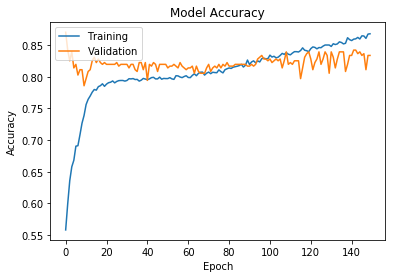

In [494]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

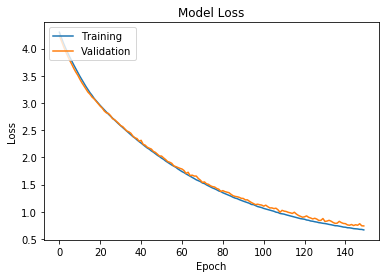

In [495]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')


plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [496]:
y_pred=model.predict_classes(x_test)

In [497]:
y_pred_new=model.predict(x_test)

In [498]:
y_test_new=[]
for i in y_test:
    y_test_new.append(np.argmax(i)) 

In [499]:
number = 0
for x,y in zip(y_pred_new,y_test_new):
    if x[1]<x[0] and y==1.0:
        print(x,y)

[0.82662344 0.17337656] 1
[0.9708036  0.02919637] 1
[0.718217 0.281783] 1
[0.95691675 0.0430832 ] 1
[0.6129512 0.3870488] 1
[0.7759681  0.22403196] 1
[0.86392784 0.13607214] 1
[0.89764374 0.10235624] 1
[0.8300422  0.16995783] 1
[0.7948382  0.20516178] 1
[0.89973235 0.10026763] 1
[0.94017446 0.05982553] 1
[0.9647412  0.03525881] 1
[0.79352826 0.20647167] 1


In [500]:
print("Confusion Matrix")
print(pd.DataFrame(confusion_matrix(y_test_new, y_pred,labels=[1,0]),
                   index=['True: yes', 'True: no'],
                   
                   columns=['Pred: yes', 'Pred: no']))

Confusion Matrix
           Pred: yes  Pred: no
True: yes         35        14
True: no          45       261


In [501]:
tn, fp, fn, tp = confusion_matrix(y_test_new, y_pred,labels=[0,1]).ravel()
print("precision_score:", tp/(fp + tp)*100, "specificity_score:", tn/(tn+fp)*100, "recall_score:", tp/(fn+tp)*100)

precision_score: 43.75 specificity_score: 85.29411764705883 recall_score: 71.42857142857143
